In [1]:
from lusidtools.jupyter_tools import toggle_code

"""
Building a model portfolio with DEI data from Denominator

Attributes
----------
DEI
ESG
Model portfolios
Reference portfolios
luminesce
lumipy
"""

toggle_code("Toggle Docstring")

# Building a model portfolio with DEI data from Denominator

In this notebook we build a [model portfolio](https://support.lusid.com/knowledgebase/article/KA-01852/en-us) in LUSID using DEI data from [Denominator](https://www.denominator.one/). For example, you might want to build a portfolio using stocks with a positive Gender score in the top quartile only. We can use data from Denominator to automate the construction of this portfolio in LUSID.

Background on Denominator:

> All DEI data is provided by [Denominator](https://www.denominator.one/). Denominator provides fact-based standards and transparency to Diversity, Equity, & Inclusion (DEI) and has the largest DEI database in the world covering 1.7 million companies across 210 countries and 88 industries on up to 200 unique DEI variables. Please contact your FINBOURNE Customer Success representative for more information on accessing Denominator data within your LUSID domain

<div>
<img src="./logo/denominator_logo.GIF" width="600">
</div>


<span style="color:darkred"> <b>DISCLAIMER: The data is for illustrative purposes only on a limited demo universe and data may not be fully up to date. A subscription is needed for updated data on the full company universe.</b></span>




###  Table of contents

* [1. Setup](#setup)
* [2. Create properties for DEI metrics](#properties)
* [3. Load instruments with DEI data into LUSID](#load-instruments)
* [4. Generate universe of DEI instuments](#gen-instruments)
* [5. Generate model portfolio with Gender score in top 10%](#model-port-gender)
* [6. Generate model portfolio with Total DEI score in top 5%](#model-port-total)

## 1. Setup <a name="setup"></a>

First we install the python packages needed to run this notebook.

In [2]:
# Use first block to import generic non-LUSID packages
import os
import pandas as pd
import datetime
import json
import pytz
from IPython.core.display import HTML

# Then import the key modules from the LUSID package (i.e. The LUSID SDK)
import lusid as lu
import lusid.api as la
import lusid.models as lm
import lumipy as lumi

# And use absolute imports to import key functions from Lusid-Python-Tools and other helper package

from lusid.utilities import ApiClientFactory
from lusidjam import RefreshingToken
from lusidtools.cocoon.cocoon import load_from_data_frame
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from lusidtools.jupyter_tools import StopExecution
from dei_model_builder import (
    get_instruments_with_dei_data,
    dei_filter_by_quantiles,
    build_equally_weighted_model_portfolio,
    get_model_portfolio,
)

# Plotting packages

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

# Set DataFrame display formats
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
display(HTML("<style>.container { width:90% !important; }</style>"))

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")
token = RefreshingToken()

api_factory = ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path,
    app_name="LusidJupyterNotebook",
)

api_status = pd.DataFrame(
    api_factory.build(lu.ApplicationMetadataApi).get_lusid_versions().to_dict()
)

display(api_status)

,api_version,build_version,excel_version,links
0,v0,0.6.9685.0,0.5.2945,"{'relation': 'RequestLogs', 'href': 'http://st..."


In [3]:
portfolio_api = api_factory.build(lu.api.PortfoliosApi)
properties_api = api_factory.build(lu.api.PropertyDefinitionsApi)
instruments_api = api_factory.build(lu.api.InstrumentsApi)
reference_portfolios_api = api_factory.build(lu.api.ReferencePortfolioApi)
search_api = api_factory.build(lu.api.SearchApi)

In [4]:
scope = "DEI"

## 2. Create properties for DEI metrics <a name="properties"></a>

Next, we create [properties](https://support.lusid.com/knowledgebase/article/KA-01855/en-us) in LUSID to capture six DEI metrics. These properties are stored against [instruments](https://support.lusid.com/knowledgebase/article/KA-01863/en-us) in LUSID. The underlying DEI data is loaded from Denominator.

Further information on each Denominator metric below:

#### Total DEI Score

> Denominator’s Total DEI Scores considers up to 200 unique variables across 15 dimensions of DEI. Examples of dimensions include Gender, Race, Education, Family, Sexuality, Nationality, Disability, and Health.


#### Board DEI Score

> Denominator’s Board DEI Score considers variables pertaining to the Board of Directors of a company across several dimensions of DEI. Examples of dimensions include Gender, Race, Education, Family, Sexuality, and Nationality.

#### Executive DEI Score

> Denominator’s Executive DEI Score considers variables pertaining to the Executive Management of a company across several dimensions of DEI. Examples of dimensions include Gender, Race, Education, Family, Sexuality, and Nationality.

#### Gender DEI Score

> Denominator’s Gender DEI Score considers variables on gender across a company’s Board of Directors, Executive Management, and their entire workforce. Some of the measured variables include representation of women, availability of maternity leave, length of leave, non-discriminatory practices, inclusive policies and many more.


####  % Distribution of Caucasian executives

> Denominator’s % Distribution of Caucasian executives considers proportion of Caucasian executives.


<span style="color:darkred"> For more information on Denominator’s methodology, please contact your Customer Success representative or the FINBOURNE support team on support@lusid.com. </span>


In [5]:
properties = [
    "Board DEI Score",
    "Gender DEI Score",
    "Executive DEI Score",
    "Gender DEI Score",
    "Pct Distribution of Caucasian Executives",
]

for property_name in properties:

    property_code = property_name.title().replace(" ", "")

    try:

        properties_api.create_property_definition(
            create_property_definition_request=lm.CreatePropertyDefinitionRequest(
                domain="Instrument",
                scope=scope,
                code=property_code,
                display_name=property_name,
                data_type_id=lm.ResourceId(code="number", scope="system"),
            )
        )

    except lu.ApiException as e:
        print(json.loads(e.body)["title"])

Error creating Property Definition 'Instrument/DEI/BoardDeiScore' because it already exists.
Error creating Property Definition 'Instrument/DEI/GenderDeiScore' because it already exists.
Error creating Property Definition 'Instrument/DEI/ExecutiveDeiScore' because it already exists.
Error creating Property Definition 'Instrument/DEI/GenderDeiScore' because it already exists.
Error creating Property Definition 'Instrument/DEI/PctDistributionOfCaucasianExecutives' because it already exists.


## 3. Load instruments with DEI data into LUSID <a name="load-instruments"></a>

Next we create the instruments in LUSID adding the DEI metrics as properties on the instruments. In this example, we load the instruments and metrics from a CSV file.

In [6]:
instrument_master = pd.read_csv("data/sp_500_dei_data.csv")

# Remove commas and other characters
# These characters are breaking the data load

instrument_master["DisplayName"] = instrument_master["DisplayName"].str.replace(
    "[^a-zA-Z ]", ""
)
instrument_master["AssetClass"] = "Equities"
instrument_master["DomCcy"] = "GBP"
instrument_master["Scope"] = scope
instrument_master["DeiMetrics"] = "Y"
display(instrument_master.head(5))

,DisplayName,DeiIdNumber,Figi,TotalDeiScore,BoardDeiScore,ExecutiveDeiScore,GenderDeiScore,PctDistributionOfCaucasianExecutives,AssetClass,DomCcy,Scope,DeiMetrics
0,M COMPANY,1345634,US88579Y1010,56.79,56.57,37.85,56.56,0.8462,Equities,GBP,DEI,Y
1,A O SMITH CORPORATION,648856,US8318652091,50.67,49.16,34.13,41.45,0.8667,Equities,GBP,DEI,Y
2,ABBVIE INC,1547048,US00287Y1091,58.04,41.60,51.53,64.18,0.9000,Equities,GBP,DEI,Y
3,Abiomed Inc,1522592,US0036541003,47.16,47.34,27.52,33.81,0.9091,Equities,GBP,DEI,Y
4,Accenture PLC,1741869,IE00B4BNMY34,60.66,57.76,40.75,67.46,0.8696,Equities,GBP,DEI,Y


In [7]:
# Create dictionaries of mappings

mapping_required = {
    "name": "DisplayName",
    "definition.dom_ccy": "$USD",
    "definition.instrument_type": "$SimpleInstrument",
    "definition.simple_instrument_type": "$Equities",
    "definition.asset_class": "$Equities",
}

identifiers = {"Figi": "Figi"}

properties = [
    "TotalDeiScore",
    "BoardDeiScore",
    "ExecutiveDeiScore",
    "GenderDeiScore",
    "PctDistributionOfCaucasianExecutives",
    "DeiMetrics",
]

# Load instruments into LUSID

response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=instrument_master,
    mapping_required=mapping_required,
    mapping_optional={},
    file_type="instruments",
    property_columns=properties,
    properties_scope=scope,
    identifier_mapping=identifiers,
)

## 4. Generate universe of DEI instuments <a name="gen-instruments"></a>

Next query back the universe of DEI instruments.

In [8]:
df_all_dei_data = get_instruments_with_dei_data()
df_all_dei_data.head(5)

,lusid_instrument_id,name,TotalDeiScore,BoardDeiScore,ExecutiveDeiScore,GenderDeiScore,PctDistributionOfCaucasianExecutives
0,LUID_00003DXW,ROPER TECHNOLOGIES INC,34.57,40.31,21.45,20.00,0.0000
1,LUID_00003E5J,PerkinElmer Inc,34.23,31.43,22.78,36.59,0.2857
2,LUID_00003DUM,Target Corporation,52.10,51.77,54.04,61.24,0.1818
3,LUID_00003E1Z,VENTAS INC,48.61,53.69,37.10,56.64,0.0625
4,LUID_00003E0P,AMETEK INC,47.75,50.74,10.50,22.50,0.0000


## 5. Generate model portfolio with Gender score in 90th percentile  <a name="model-port-gender"></a>

Once we have the universe of DEI instruments, we can start to create some model portfolios. We'll start with a gender focused model portfolio which is built using instruments with a `GenderDeiScore` in the top 10%.

We use the [quantile](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) function of [pandas](https://pandas.pydata.org/docs/index.html) to filter the data. 

We plot the distribution of gender scores below:

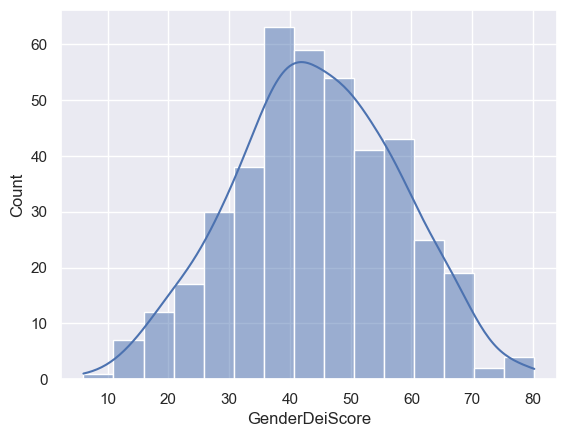

In [9]:
sns.histplot(data=df_all_dei_data["GenderDeiScore"], kde=True)
plt.show()

### 5.1 Collect instruments with a strong GenderDeiScore

<i>(We also make sure that the other DEI attributes are in the top 50th percentile)<i/>

In [10]:
gender_focused_instruments = dei_filter_by_quantiles(
    df_all_dei_data,
    gender_dei_quantile_value=0.9,
    executive_dei_quantile_value=0.5,
    board_dei_quantile_value=0.5,
    total_dei_quantile_value=0.5,
    pct_dist_cauc_ex_quantile_value=0.5,
)
gender_focused_instruments.head(5)

,lusid_instrument_id,name,TotalDeiScore,BoardDeiScore,ExecutiveDeiScore,GenderDeiScore,PctDistributionOfCaucasianExecutives
281,LUID_00003E0R,JOHNSON JOHNSON,63.03,48.57,48.35,63.26,0.1667
96,LUID_00003E0Z,THE COCACOLA COMPANY,61.38,57.95,56.26,78.38,0.4500
199,LUID_00003E2N,Accenture PLC,60.66,57.76,40.75,67.46,0.1304
143,LUID_00003DUS,STARBUCKS CORPORATION,59.40,54.35,62.51,76.02,0.2000
347,LUID_00003E39,CITIGROUP INC,59.23,56.09,48.90,69.71,0.3333


### 5.2 Build model portfolio with strong GenderDeiScore

We use the gender focused list to build a model portfolio of 20 stocks.

In [11]:
portfolio_code = "ModelGenderTop"
model_portfolio = build_equally_weighted_model_portfolio(
    portfolio_code, scope, gender_focused_instruments
)

Could not create a portfolio with id 'ModelGenderTop' because it already exists in scope 'DEI'.


The portfolio has now been created in LUSID and you can query its constituents using [GetReferencePortfolioConstituents](https://www.lusid.com/docs/api/#operation/GetReferencePortfolioConstituents). This API is called by the `get_model_portfolio` function below:

In [12]:
get_model_portfolio(scope, portfolio_code)

,name,weight,currency,board_dei_score,executive_dei_score,gender_dei_score,total_dei_score
0,JOHNSON JOHNSON,5.0,USD,48.57,48.35,63.26,63.03
1,THE COCACOLA COMPANY,5.0,USD,57.95,56.26,78.38,61.38
2,Accenture PLC,5.0,USD,57.76,40.75,67.46,60.66
3,STARBUCKS CORPORATION,5.0,USD,54.35,62.51,76.02,59.40
4,CITIGROUP INC,5.0,USD,56.09,48.90,69.71,59.23
5,GILEAD SCIENCES INC,5.0,USD,50.59,66.71,68.58,58.60
6,THE CLOROX COMPANY,5.0,USD,54.20,61.18,66.65,58.31
7,CELANESE CORPORATION,5.0,USD,57.89,55.81,67.40,58.30
8,HUNTINGTON BANCSHARES INCORPORATED,5.0,USD,50.97,50.39,65.00,58.23
9,BRISTOLMYERS SQUIBB COMPANY,5.0,USD,58.49,62.53,74.23,58.13


## 6. Generate model portfolio with Total DEI score in the 95th percentile <a name="model-port-total"></a>

Next we generate another model portfolio, this time with a Total DEI score focus. This portfolio will use stocks with a Total DEI score in the top 5%. The other four metrics are in top 50% of observations. We plot the distribution of total DEI scores below:

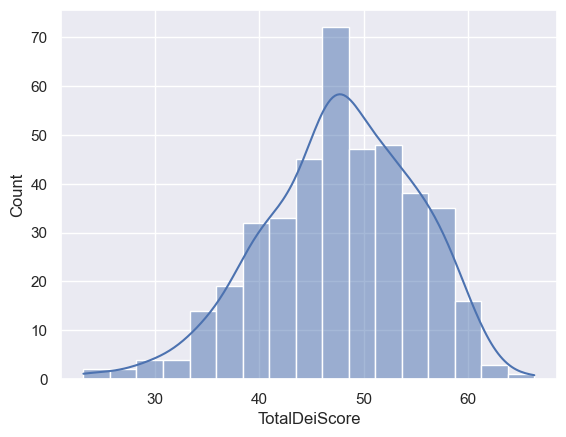

In [13]:
sns.histplot(data=df_all_dei_data["TotalDeiScore"], kde=True)
plt.show()

### 6.1 Collect instruments with a strong TotalDeiScore

<i>(We also make sure that the other DEI attributes are in the top 50th percentile)<i/>

In [14]:
total_focused_instruments = dei_filter_by_quantiles(
    df_all_dei_data,
    total_dei_quantile_value=0.95,
    executive_dei_quantile_value=0.5,
    board_dei_quantile_value=0.5,
    gender_dei_quantile_value=0.5,
    pct_dist_cauc_ex_quantile_value=0.5,
)
total_focused_instruments.head(5)

,lusid_instrument_id,name,TotalDeiScore,BoardDeiScore,ExecutiveDeiScore,GenderDeiScore,PctDistributionOfCaucasianExecutives
281,LUID_00003E0R,JOHNSON JOHNSON,63.03,48.57,48.35,63.26,0.1667
96,LUID_00003E0Z,THE COCACOLA COMPANY,61.38,57.95,56.26,78.38,0.4500
199,LUID_00003E2N,Accenture PLC,60.66,57.76,40.75,67.46,0.1304
371,LUID_00003DVL,The Progressive Corporation,60.00,53.91,47.50,50.61,0.1667
144,LUID_00003DYV,US BANCORP,59.55,62.23,39.65,58.27,0.2143


### 6.2 Build model portfolio with strong TotalDeiScore

We use the Total DEI focused list to build a model portfolio of 5 stocks. These are the top 5 stocks in the Top 5% of observations. The model portfolio is equally weighted with 20% allocated to each stock.

In [15]:
portfolio_code = "ModelTotalDeiTop5"
model_portfolio = build_equally_weighted_model_portfolio(
    portfolio_code, scope, total_focused_instruments, 5
)

Could not create a portfolio with id 'ModelTotalDeiTop5' because it already exists in scope 'DEI'.


The portfolio has now been created in LUSID and you can query its constituents using [GetReferencePortfolioConstituents](https://www.lusid.com/docs/api/#operation/GetReferencePortfolioConstituents). This API is called by the `get_model_portfolio` function below:

In [16]:
get_model_portfolio(scope, portfolio_code)

,name,weight,currency,board_dei_score,executive_dei_score,gender_dei_score,total_dei_score
0,JOHNSON JOHNSON,20.0,USD,48.57,48.35,63.26,63.03
1,THE COCACOLA COMPANY,20.0,USD,57.95,56.26,78.38,61.38
2,Accenture PLC,20.0,USD,57.76,40.75,67.46,60.66
3,The Progressive Corporation,20.0,USD,53.91,47.50,50.61,60.00
4,US BANCORP,20.0,USD,62.23,39.65,58.27,59.55
